In [1]:
# Imports
import pandas as pd
import pickle
from typing import List, Tuple
import matplotlib.pyplot as plt
import re

In [2]:
# emails : pd.DataFrame, represents the initial emails dataset after few preprocessing steps by TEAM 1
df = pd.read_csv('emails.csv', low_memory=False)
df.shape, df.columns

((517401, 9),
 Index(['id', 'date', 'from', 'xfrom', 'to', 'xto', 'xcc', 'subject', 'body'], dtype='object'))

In [3]:
df.head(2)

,id,date,from,xfrom,to,xto,xcc,subject,body
0,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,Phillip K Allen,tim.belden@enron.com,Tim Belden <Tim Belden/Enron@EnronXGate>,NaN,Mime-Version: 1.0,Here is our forecast
1,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,Phillip K Allen,john.lavorato@enron.com,John J Lavorato <John J Lavorato/ENRON@enronXg...,NaN,Re:,Traveling to have a business meeting takes the...


In [4]:
def plot_na(data:pd.DataFrame) -> None:
    """
    Plot the missing values in the dataset

    Params:
        data (pd.DataFrame): Input dataset

    Returns:
        None
    """
    missing_percentage = data.isnull().mean() * 100  
    missing_count = data.isnull().sum()

    stats_sorted = missing_percentage.sort_values(ascending=False)
    counts_sorted = missing_count[stats_sorted.index]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(stats_sorted.index, stats_sorted.values, color='skyblue')

    for bar, count in zip(bars, counts_sorted.values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + (max(stats_sorted.values) * 0.01),
            f"{count:,}", 
            ha='center', va='bottom', fontsize=10
        )

    plt.title("Pourcentage de valeurs manquantes par colonne avec count", fontsize=16)
    plt.xlabel("Colonnes", fontsize=12)
    plt.ylabel("Pourcentage de valeurs manquantes (%)", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

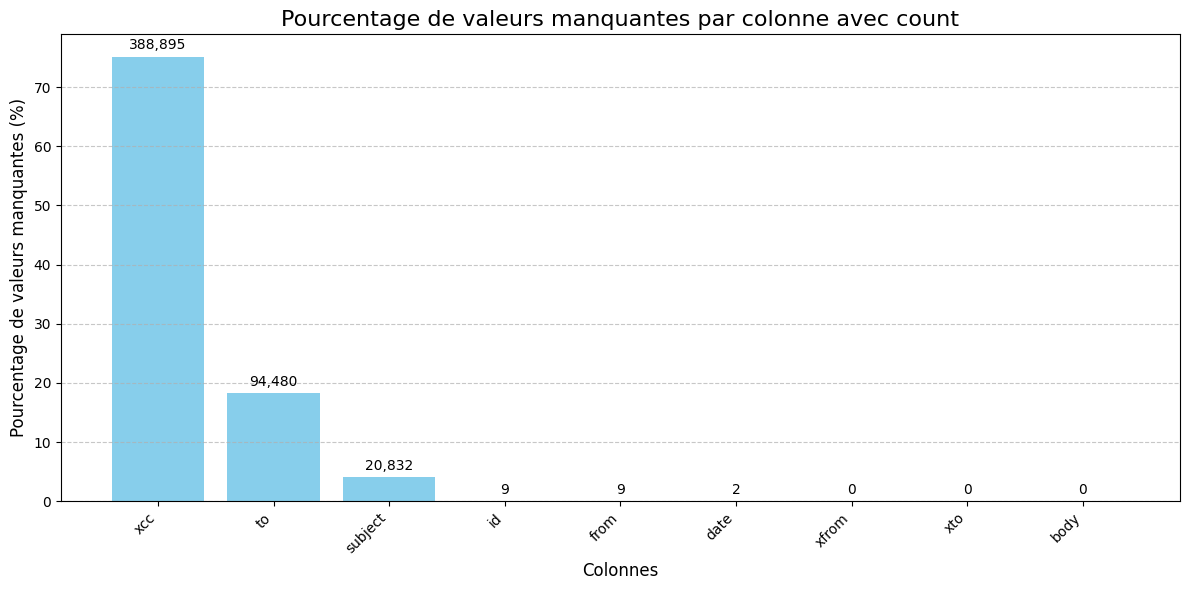

In [5]:
plot_na(df)

In [6]:
df.sort_values(by=['from', 'date'], inplace=True)
df.drop(columns=['id', 'date', 'xto', 'xcc', 'to'], inplace=True)

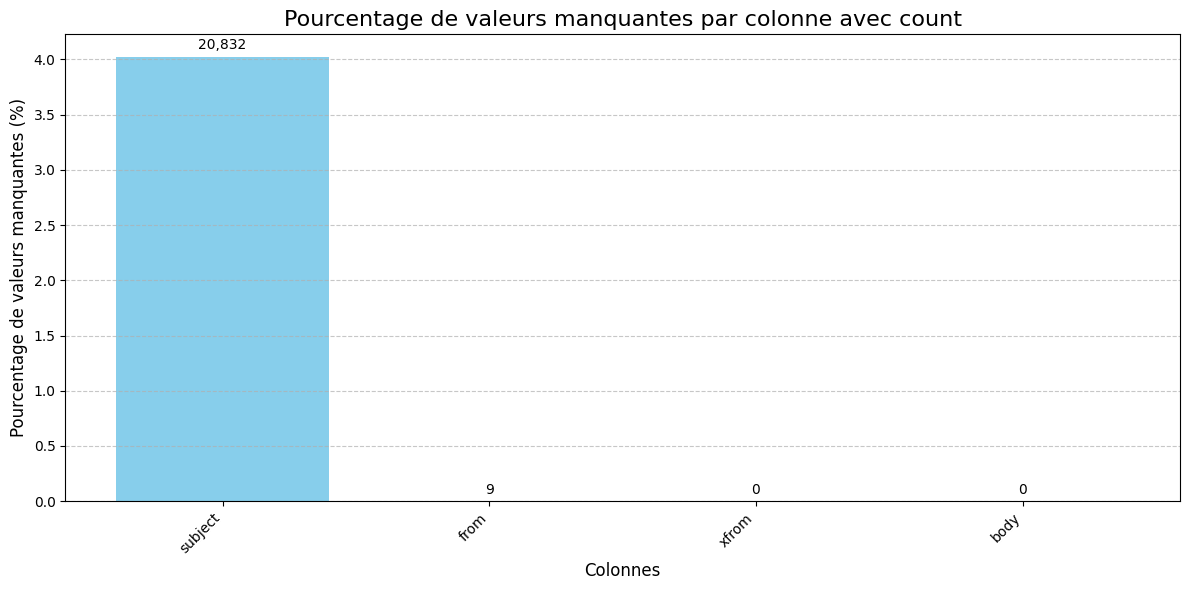

In [7]:
plot_na(df)

In [8]:
df.dropna(inplace=True)
unique_senders = df['from'].unique()
len(unique_senders)

36213

In [9]:
def keep_valid_senders(X) -> Tuple[List[str], List[str]]:
    """Keep only valid senders

    Params:
        X : list of senders
    
    Returns:
        List[str]: list of valid senders
    """
    enron_senders = [sender for sender in X if 'enron' in sender.lower()]
    news_senders = [sender for sender in X if 'news' in sender.lower()]
    no_reply_senders = [sender for sender in X if 'no-reply' in sender.lower()]

    with open('not_enron_correct_mails.pkl', 'rb') as f:
        not_enron_correct_mails = pickle.load(f)
    
    concat_good_senders = enron_senders + not_enron_correct_mails
    concat_good_senders = [sender for sender in concat_good_senders if sender not in news_senders]
    concat_good_senders = [sender for sender in concat_good_senders if sender not in no_reply_senders]
    concat_good_senders = [sender for sender in concat_good_senders if "announcement" not in sender.lower()]
    
    # keep only enron senders that are like nom.prenom@enron.com only with a regex
    matching_re = re.compile(r'^[a-zA-Z]+(?:\.[a-zA-Z]+)?@enron\.com$')
    enron_valid = [sender for sender in concat_good_senders if matching_re.match(sender) is not None]
    return concat_good_senders, enron_valid


In [10]:
concat_good_senders, enron_valid = keep_valid_senders(unique_senders)
len(concat_good_senders), len(enron_valid)

(12708, 5530)

In [11]:
# keep data with enron senders only
X = df[df['from'].isin(enron_valid)]
X.shape

(316500, 4)

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 316500 entries, 208382 to 249219
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   from     316500 non-null  object
 1   xfrom    316500 non-null  object
 2   subject  316500 non-null  object
 3   body     316500 non-null  object
dtypes: object(4)
memory usage: 12.1+ MB


In [13]:
sender_counts = X['from'].value_counts()
print(sender_counts.describe())

count     5530.000000
mean        57.233273
std        413.689052
min          1.000000
25%          2.000000
50%          6.000000
75%         19.000000
max      12320.000000
Name: count, dtype: float64


In [14]:
# save enron senders
with open('valid_enron_senders.pkl', 'wb') as f:
    pickle.dump(enron_valid, f)

In [15]:
max_mails = X['from'].value_counts().max()
# Identifier l'utilisateur correspondant
user_with_max_mails = X['from'].value_counts()[X['from'].value_counts() == max_mails]
print(user_with_max_mails)

from
vince.kaminski@enron.com    12320
Name: count, dtype: int64


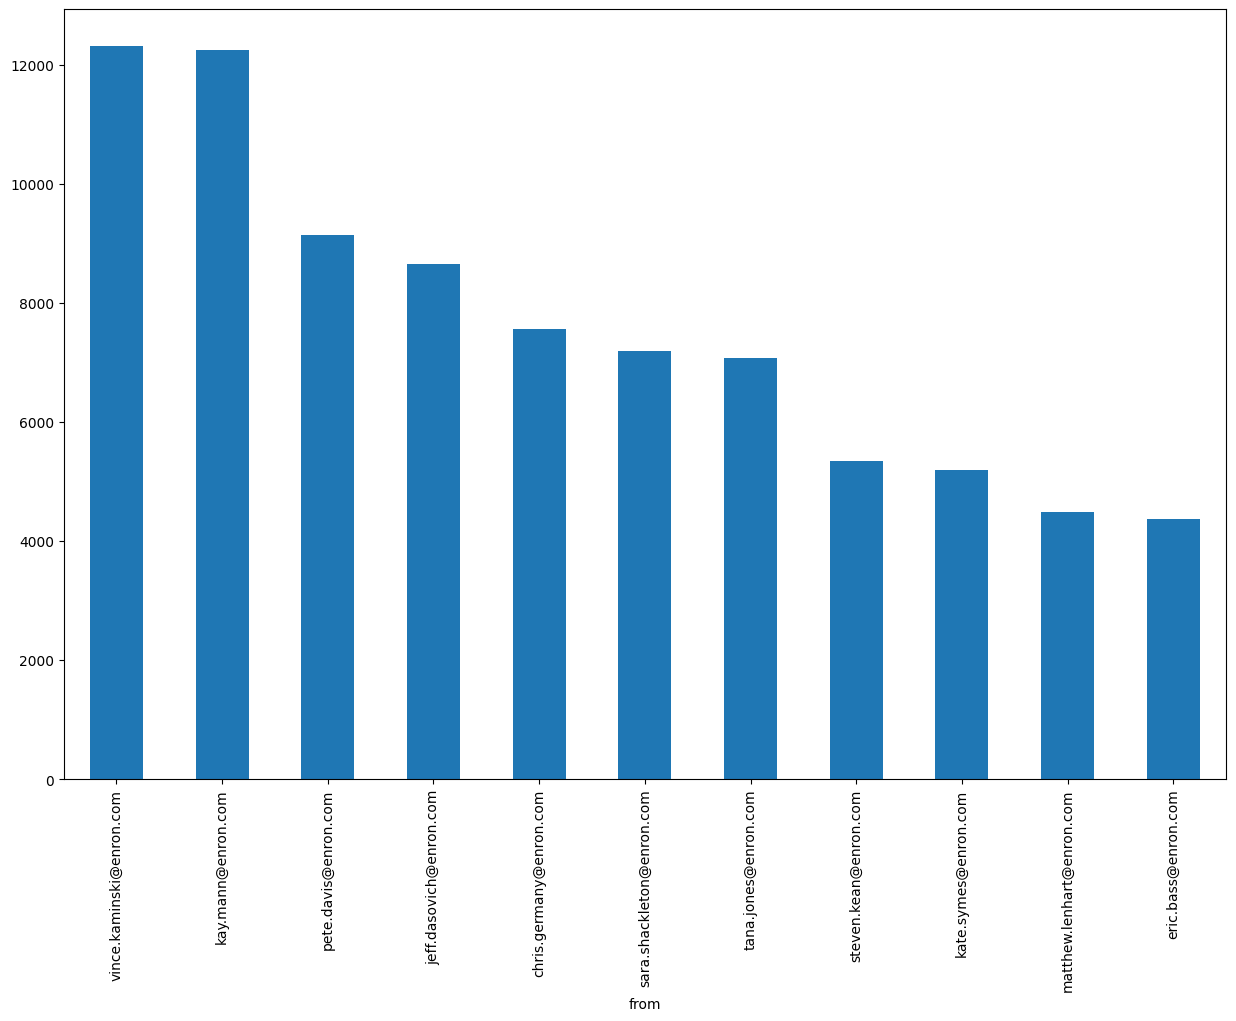

In [16]:
# plot the top 10 mails per senders
plt.figure(figsize=(15, 10))
X['from'].value_counts().head(11).plot(kind='bar')
plt.show()

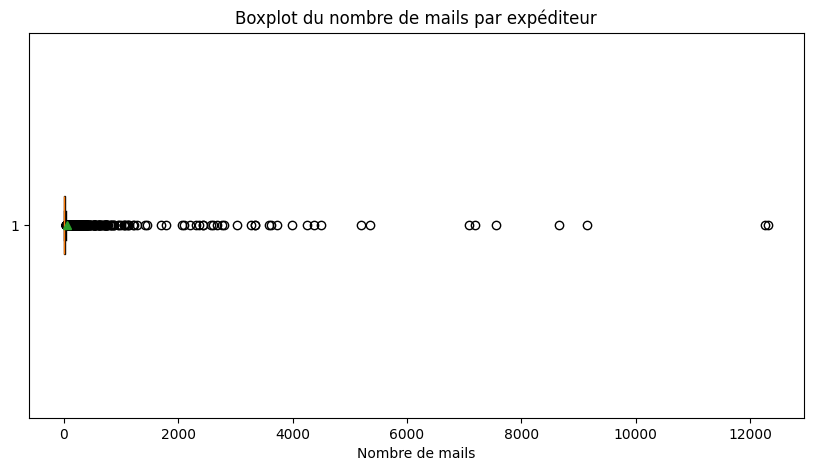

In [17]:
# Compter le nombre d'emails par expéditeur
sender_counts = X['from'].value_counts()
# Créer un boxplot
plt.figure(figsize=(10, 5))
plt.boxplot(sender_counts, vert=False, patch_artist=True, showmeans=True)
plt.title("Boxplot du nombre de mails par expéditeur")
plt.xlabel("Nombre de mails")
plt.show()


In [18]:
sender_counts[sender_counts >=19].count(), sender_counts[sender_counts < 19].count()

(1433, 4097)

In [19]:
# keep only users with more than 10 mails
X = X[X['from'].isin(sender_counts[sender_counts >= 19].index)]

In [20]:
sender_counts = X['from'].value_counts()
print(sender_counts.describe())

count     1433.000000
mean       206.748081
std        794.055825
min         19.000000
25%         28.000000
50%         47.000000
75%        111.000000
max      12320.000000
Name: count, dtype: float64


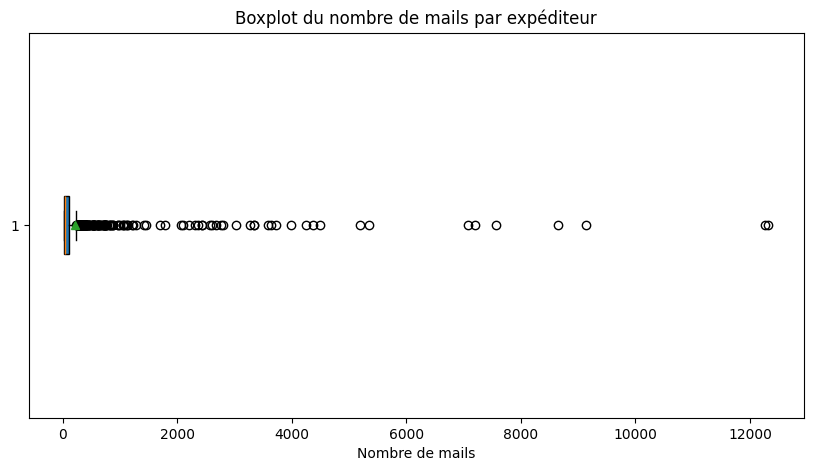

In [21]:
# Compter le nombre d'emails par expéditeur
sender_counts = X['from'].value_counts()

# Créer un boxplot
plt.figure(figsize=(10, 5))
plt.boxplot(sender_counts, vert=False, patch_artist=True, showmeans=True)
plt.title("Boxplot du nombre de mails par expéditeur")
plt.xlabel("Nombre de mails")
plt.show()


In [22]:
# save X
X.to_csv('enron.csv', index=False)